In [2]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

In [3]:
class ReadStandardTime:
    def __init__(self,Path):
        self.Master = pd.read_csv(Path,delimiter = ',',header = 0,na_values = -9999)
        self.Master = self.Master.set_index(pd.DatetimeIndex(pd.to_datetime(self.Master['datetime'])))
        self.Master['DOY'] = self.Master.index.dayofyear*1.0
        self.Master['HR'] = self.Master.index.hour*1.0
        
    def Scale(self,y_var,X_vars):
        self.y_var = y_var
        self.Data = self.Master[np.isfinite(self.Master[y_var])]
        self.Data = self.Data.interpolate().bfill()
        self.Data = self.Data.interpolate().ffill()
        self.y = self.Data[y_var].values
        YStandard = StandardScaler()
        self.YScaled = YStandard.fit(self.y.reshape(-1, 1))
        Yscale = self.YScaled.transform(self.y.reshape(-1, 1))
        self.y = np.ndarray.flatten(Yscale)
        self.Ytru = self.YScaled.inverse_transform(self.y.reshape(-1,1))
        X = self.Data[X_vars]
        self.input_shape = len(X_vars)
        XStandard = StandardScaler()
        self.XScaled= XStandard.fit(X)
        self.X = self.XScaled.transform(X)
        Filling = self.Master[X_vars]
        Filling = Filling.interpolate().bfill()
        Filling = Filling.interpolate().ffill()
        XStandard = StandardScaler()
        self.XFillScaled= XStandard.fit(Filling)
        self.X_fill = self.XScaled.transform(Filling)
        
    def TimeShape(self,rolls):
        X1 = self.X
        Xf = self.X_fill
        self.X_time = np.zeros(shape = (X1.shape[0],rolls+1,X1.shape[1]))
        self.X_time[:,0,:] = X1
        self.X_ftime = np.zeros(shape = (Xf.shape[0],rolls+1,Xf.shape[1]))
        self.X_ftime[:,0,:] = Xf
        if rolls > 0:
            for roll in range(0,rolls):
                X2 = np.roll(X1,(roll+1),axis=0)
                X2f = np.roll(Xf,(roll+1),axis=0)
                self.X_time[:,roll+1,:] = X2
                self.X_ftime[:,roll+1,:] = Xf
        self.X_time = self.X_time[rolls+1:,:,:]
        self.X_ftime = self.X_ftime[rolls+1:,:,:]
        self.y_time = self.y[rolls+1:]
        self.y_ftime = self.y[rolls+1:]
        self.TimeSteps = rolls+1
        
    def Fill(self,Y_Pred):
        Y_fill = self.YScaled.inverse_transform(Y_Pred.reshape(-1,1))
        nanz = np.zeros(shape=(self.TimeSteps,1))
        nanz[:,:] = np.nan
        Y_Pred = np.concatenate((nanz,Y_fill),axis=0).reshape(-1,1)
        self.Master['TempFIll'] = Y_Pred
        self.Master[self.y_var+'_Filled'] = self.Master[self.y_var].fillna(self.Master['TempFIll'])

In [4]:
def LSTM_Model(Neurons,batch_size,time_steps,inputs,lr=1e-4,Memory=.9):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
#     from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = Memory
    session = tf.Session(config=config)
    model = Sequential()
    model.add(LSTM(Neurons, input_shape=(time_steps,inputs),stateful = False))
    model.add(Dense(1))
    NUM_GPU = 1 # or the number of GPUs available on your machine
    
    adam = keras.optimizers.Adam(lr = lr)
    gpu_list = []
    for i in range(NUM_GPU): gpu_list.append('gpu(%d)' % i)
    model.compile(loss='mean_squared_error', optimizer='adam')#,context=gpu_list) # - Add if using MXNET
    return(model)

def Train_Steps(epochs,Neurons,X_train,X_test,X_val,y_train,y_test,y_val,rs,i=None,Memory=None):
    
    np.random.seed(i)
    from keras import backend as K
#     epochs = 100
    Scorez=[]
    lr = 1e-3
    Mod = LSTM_Model(Neurons,X_train.shape[0],X_train.shape[1],X_train.shape[2],lr=lr,Memory=Memory)
    killscore=0
    killmax = 10
    e = 0
    udate = 3
    np.random.seed(rs)
    while killscore < killmax and e < epochs:
#         print(e)
        Mod.fit(X_train,y_train,batch_size=X_train.shape[0], nb_epoch=1,shuffle=True,verbose=0)
        old_weights = Mod.get_weights()
        Y = Mod.predict(X_test,batch_size =X_test.shape[0])
        score = metrics.mean_squared_error(y_test,Y)
        Scorez.append(score)
        if e == 0:
            score_min=score
            min_weights=old_weights
        elif score < score_min:
            score_min = score
            min_weights=old_weights
            killscore = 0
        else:
            killscore +=1
        if killscore == math.floor(killmax/2):
            K.set_value(Mod.optimizer.lr, 0.5 * K.get_value(Mod.optimizer.lr))
#             print(K.get_value(Mod.optimizer.lr))
        Mod.reset_states()
        e +=1
#         print(e,killscore)
    Mod.set_weights(min_weights)
    Yval = Mod.predict(X_val,batch_size = X_val.shape[0])
    MSE = (metrics.mean_squared_error(y_val,Yval))
    Scorez=np.asanyarray(Scorez)
    return(MSE,min_weights)
           
# def RunFunc(i,processes,Modz,reps,time_steps,Neurons,epochs):
def RunFunc(i,processes,Modz,reps,epochs,params):
    print(params.iloc[i])
    time_steps = params['T'].iloc[i]
    Neurons = params['N'].iloc[i]
#     np.random.seed(i)
    Path = 'QuickData_FI.csv' 
#     CH4_Model = ['Sedge','Temp','VWC','ustar','air_pressure','PPFD_Avg']
    RST = ReadStandardTime(Path)
    offset = 5/processes
    Memory = (math.floor(100/processes)- offset) * .01
    MSE = []

#     M = Model#Modz[i]
    RST.Scale('co2_flux',Model)
    RST.TimeShape(time_steps)
    y = RST.y_time*1.0
    X = RST.X_time*1.0
    for r in range(reps):
        X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=r)
        X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=r)
        mse,w=Train_Steps(epochs,Neurons,X_train,X_test,X_val,y_train,y_test,y_val,rs=i,i=r,Memory=Memory)
        MSE.append(mse)
    mse = np.asanyarray(MSE)
    mse,std = mse.mean(),mse.std()
    return(mse,std)

      N  T  MSE  STD
0   133  5  0.0  0.0
1   193  0  0.0  0.0
2     4  1  0.0  0.0
3   135  2  0.0  0.0
4   212  2  0.0  0.0
5   286  0  0.0  0.0
6   252  2  0.0  0.0
7    84  4  0.0  0.0
8   232  5  0.0  0.0
9   213  4  0.0  0.0
10   25  1  0.0  0.0
11  152  3  0.0  0.0
12   79  4  0.0  0.0
13  199  4  0.0  0.0
14  114  3  0.0  0.0
15  274  2  0.0  0.0
16  151  3  0.0  0.0
17  110  5  0.0  0.0
18  102  3  0.0  0.0
19  250  1  0.0  0.0
20    4  1  0.0  0.0
21  112  4  0.0  0.0
22  179  1  0.0  0.0
23  253  2  0.0  0.0
24   74  2  0.0  0.0 10


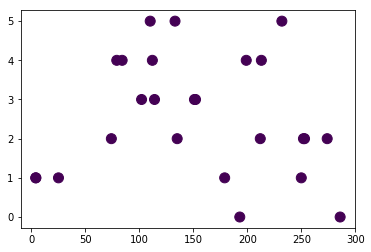

In [14]:
class Params:
    def __init__(self,Func,samp_size):
#         N_start=[]
#         T_start=[]
        if Func == 'Quick':            
            epochs = 1000
            reps = 10
            N_Max = 300
            T_Max = 6
#             N_start =[x*50+5 for x in range(5)]
#             T_start =[x*2 for x in range(3)]
#             cycles = reps*len(N_start)*len(T_start)
        elif Func == 'Full':
            epochs = 2000
            reps = 100
            N_Max = 200
            T_Max = 12
#             N_start = [x*25+5 for x in range(5)]
#             T_start = [x*2 for x in range(5)]
#             cycles = reps*len(N_start)*len(T_start)
        else:
            epochs = 100
            reps = 5
            N_Max = 100
            T_Max = 6
        N = np.array(np.random.rand(samp_size)*N_Max,dtype='int32')
        T = np.array(np.random.rand(samp_size)*T_Max,dtype='int32')
        d = {'N':N,'T':T}
        self.Runs = pd.DataFrame(data=d)
        self.reps = reps
        self.epochs= epochs
        self.T_Max = T_Max
        self.N_Max = N_Max

rpms = Params('Quick',25)#'Quick Run')
Runs,reps,epochs = rpms.Runs,rpms.reps,rpms.epochs
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs,reps)
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

In [11]:
# pool.close()

N      133.0
T        5.0
MSE      0.0
STD      0.0
Name: 0, dtype: float64N      193.0
T        0.0
MSE      0.0
STD      0.0
Name: 1, dtype: float64
N      4.0
T      1.0
MSE    0.0
STD    0.0
Name: 2, dtype: float64



Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


N      135.0
T        2.0
MSE      0.0
STD      0.0
Name: 3, dtype: float64
(0, (0.086633824186687497, 0.011941391367621899))
N      212.0
T        2.0
MSE      0.0
STD      0.0
Name: 4, dtype: float64
(1, (0.10153762557247595, 0.029584706294042348))
N      286.0
T        0.0
MSE      0.0
STD      0.0
Name: 5, dtype: float64
(2, (0.14747982156349004, 0.025147539636725318))
N      252.0
T        2.0
MSE      0.0
STD      0.0
Name: 6, dtype: float64
(3, (0.074851959798957715, 0.0081307373959433864))
N      84.0
T       4.0
MSE     0.0
STD     0.0
Name: 7, dtype: float64
(4, (0.093793075102853604, 0.053748295248182337))
N      232.0
T        5.0
MSE      0.0
STD      0.0
Name: 8, dtype: float64
(5, (0.099868042023489229, 0.030796710994050059))
N      213.0
T        4.0
MSE      0.0
STD      0.0
Name: 9, dtype: float64
N      25.0
T       1.0
MSE     0.0
STD     0.0
Name: 10, dtype: float64
(6, (0.10046413067298746, 0.057125680084400471))
(7, (0.078674338584501874, 0.01202321333139466))
N 

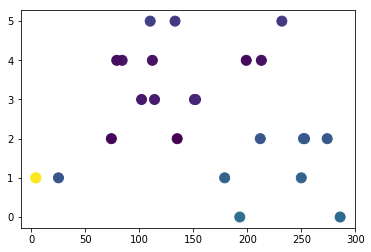

In [15]:
%matplotlib inline

# Model = ['Sedge','Shrubby','Temp','VWC','ustar','wind_speed','air_pressure',
#          'PPFD_Avg','NR_Wm2_Avg','AirTC_Avg','RH','DOY']
Model = ['Temp_2_5_1','Temp_2_5_2','u*','wind_speed','air_pressure',
         'PPFD_Avg','NR_Wm2_Avg','AirTC_Avg','RH','DOY']
Time = time.time()
if __name__ == '__main__':  
    results=[]
    processes=3
    pool = Pool(processes=processes,maxtasksperchild=50)
    Results = []
#     for i in Runs.index:
#         res = RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
#         print(res)
#         Runs['MSE'][i]=res[0]
#         Runs['STD'][i]=res[1]
    
    for res in enumerate(pool.imap(partial(RunFunc,processes=processes,Modz=Model,reps=reps,
                                           epochs=epochs,params=Runs),Runs.index)):
        print(res)
        Runs['MSE'][res[0]]=res[1][0]
        Runs['STD'][res[0]]=res[1][1]
#         data = [N,res[0],res[1][0],res[1][1]]
# #             mse,std = RunFunc(T,processes,Model,rpms.reps,N,rpms.epochs)
# #             res = np.asanyarray([N,T,mse,std])
#         RES.append(data)
    print(Runs)
    pool.close()
    
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

In [16]:

x = Runs[['N','T']].values
y = Runs['MSE'].values
s = Runs['STD'].values
print(Runs)
# print(x,y,s)
# for i in [0,2,4]:
#     idx = np.where(x == i)
#     idx = np.where(x == i)[0]
#     print(idx)
#     print(x[idx,0])
#     print(y[idx])

#     plt.fill(np.concatenate([x[idx,0], (x[idx,0])[::-1]]),
#              np.concatenate([y[idx] - s[idx], (y[idx] +  s[idx])[::-1]]),
#              alpha=.2, fc='r', ec='None')

      N  T       MSE       STD
0   133  5  0.086634  0.011941
1   193  0  0.101538  0.029585
2     4  1  0.147480  0.025148
3   135  2  0.074852  0.008131
4   212  2  0.093793  0.053748
5   286  0  0.099868  0.030797
6   252  2  0.100464  0.057126
7    84  4  0.078674  0.012023
8   232  5  0.087250  0.012586
9   213  4  0.077923  0.013558
10   25  1  0.094377  0.014854
11  152  3  0.080336  0.008275
12   79  4  0.077286  0.014772
13  199  4  0.076712  0.012995
14  114  3  0.080268  0.010779
15  274  2  0.094490  0.055468
16  151  3  0.082595  0.010801
17  110  5  0.088747  0.011069
18  102  3  0.079428  0.011898
19  250  1  0.097823  0.035580
20    4  1  0.147471  0.025146
21  112  4  0.078425  0.013591
22  179  1  0.097374  0.035397
23  253  2  0.094450  0.053442
24   74  2  0.075933  0.010763


(1800,) (1800,)
6


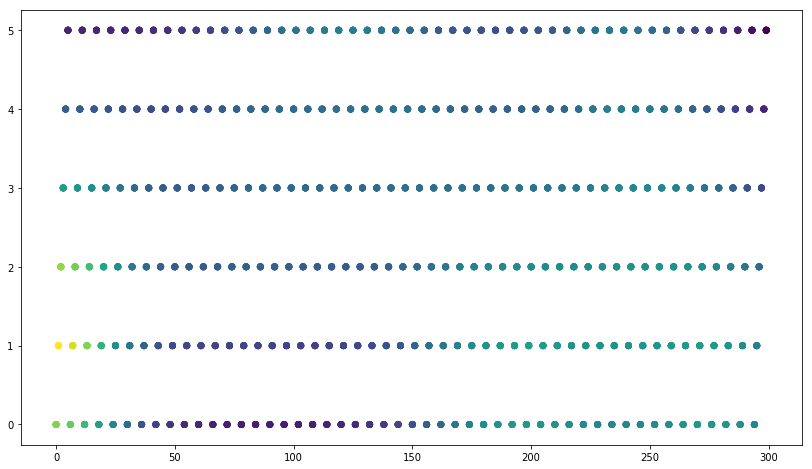

In [17]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (14, 8)
def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

kernel = Matern(length_scale = [50,3],length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha=s, random_state=0,normalize_y=False)
gp.fit(x, y)

N = [n for n in range(rpms.N_Max)]
T = [t for t in range(rpms.T_Max)]
A = [T[i] for j in range(len(N))for i in range(len(T))]
B = [N[i] for j in range(len(T))for i in range(len(N))]
T = np.asanyarray(A)
N = np.asanyarray(B)

X = np.zeros(shape=(T.shape[0],2))
X[:,0] = N
X[:,1] = T
y_pred,sigma = gp.predict(X,return_std=True)
print(y_pred.shape,sigma.shape)
# for t in range(T.max()+1):
#     t+=1
#     plt.figure()
#     plt.plot(X[(t-1)*N.shape[0]:t*N.shape[0],0],y_pred[(t-1)*N.shape[0]:t*N.shape[0]])
# #     print(y_pred[(t-1)*N.shape[0]:t*N.shape[0]])
#     plt.fill(np.concatenate([X[(t-1)*N.shape[0]:t*N.shape[0],0], (X[(t-1)*N.shape[0]:t*N.shape[0],0])[::-1]]),
#              np.concatenate([y_pred[(t-1)*N.shape[0]:t*N.shape[0]] - sigma[(t-1)*N.shape[0]:t*N.shape[0]],
#                              (y_pred[(t-1)*N.shape[0]:t*N.shape[0]] +  sigma[(t-1)*N.shape[0]:t*N.shape[0]])[::-1]]),
#              alpha=.2, fc='r', ec='None')
# plt.plot(X[:199,0],y_pred[:199])
# plt.plot(X[200:399,0],y_pred[200:399])
# plt.plot(X[400:599,0],y_pred[400:599])
# print(X[:200,0].shape,y_pred[:200].shape)
# plot(x, y, gp, filename="fig2.pdf")
# print(y_pred)
# print(y_pred.shape)
plt.figure()
plt.scatter(X[:,0],X[:,1],c=y_pred)
plt.legend()
Runs2 = Runs.copy()
# Y = y_pred.reshape(rpms.T_Max,rpms.N_Max)#[:,::-1]
# print(Y)
# # print(Y.shape)
# plt.figure()
# plt.imshow(Y[::-1])
# plt.colorbar()
# print(y_pred)

print(rpms.T_Max)

In [18]:
Cap = 220
MaxT = 6
from scipy.optimize import minimize

acq = upper_confidence_bound

def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,Cap):
        for T in np.linspace(0,MaxT):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, Cap),(0,MaxT)))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point
for i in range(5):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=s, random_state=1,normalize_y=True)
    gp.fit(x, y)
    
    next_x = query(x, y, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    res = RunFunc(idx,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(res)
    Runs['MSE'][idx]=res[0]
    Runs['STD'][idx]=res[1]
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
    x = Runs[['N','T']].values
    y = Runs['MSE'].values
    s = Runs['STD'].values
    
print(Runs)
#     res = RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
#     print(res)
#     Runs['MSE'][i]=res[0]
#     Runs['STD'][i]=res[1]
#     if N in Runs['N']:
#         o = 0
#         while next_x in Res[:,0] and next_x < Cap and next_x > 0:
#             o +=1
#             next_x += int(o*np.cos(o*np.pi))
#             print(next_x)
    
#     mse,std = RunFunc(int(next_x[1]),processes,Model,reps,int(next_x[0]),epochs)
#     res = np.asanyarray([N,T,mse,std])
#     RES.append(res)
# #         MSE.append(mse)
# #         STD.append(std)
#     Res = np.asanyarray(RES)
#     Res = Res[np.argsort(Res[:,0],axis=0),:]
# #     Res = Res[Res[:, 0].argsort()]
# #     Res.view('i8,i8,i8').sort(order=['f0'], axis=1)
#     print(Res)
#     plt.plot(Res[:,0],Res[:,1],marker = '*')
#     x = Res[:,0]
#     y = Res[:,1]
#     s = Res[:,2]
#     print(x,y)
# plt.fill(np.concatenate([x, x[::-1]]),
#          np.concatenate([y - s, (y +  s)[::-1]]),
#          alpha=.2, fc='r', ec='None')
#     plot(x, y, gp, acq=acq, next_x=next_x, filename="fig4-%d.pdf" % i)
    
#     x = np.vstack((x, next_x))
#     yi = np.concatenate((y, noise_f(xi[-1])))

[ 77.32673118   0.83158889]
77 1
MSE     0.0
N      77.0
STD     0.0
T       1.0
Name: 25, dtype: float64


Using TensorFlow backend.


(0.084486401391883958, 0.014021347743274168)
[ 75.60965933   5.12489827]
76 5
MSE     0.0
N      76.0
STD     0.0
T       5.0
Name: 26, dtype: float64
(0.088105589407228152, 0.010838010651330606)
[ 81.4062325   1.3384459]
81 1
MSE     0.0
N      81.0
STD     0.0
T       1.0
Name: 27, dtype: float64
(0.089217716942290137, 0.017280469015625927)
[ 137.32036403    4.62351125]
137 5
MSE      0.0
N      137.0
STD      0.0
T        5.0
Name: 28, dtype: float64
(0.085525137237038126, 0.011057451998055948)
[ 138.36777787    1.00375341]
138 1
MSE      0.0
N      138.0
STD      0.0
T        1.0
Name: 29, dtype: float64
(0.09119578003570035, 0.016934677604394467)
         MSE    N       STD  T
0   0.147480    4  0.025148  1
1   0.147471    4  0.025146  1
2   0.094377   25  0.014854  1
3   0.075933   74  0.010763  2
4   0.088106   76  0.010838  5
5   0.084486   77  0.014021  1
6   0.077286   79  0.014772  4
7   0.089218   81  0.017280  1
8   0.078674   84  0.012023  4
9   0.079428  102  0.011898  3

In [19]:
print(Runs[Runs['MSE'] == Runs['MSE'].min()])

         MSE    N       STD  T
14  0.074852  135  0.008131  2


In [ ]:
print(Runs)
print(x,y,s)
print(next_x)
print(int(np.round(next_x[1],0)))

In [ ]:

plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=1/Runs['STD']*100,c=Runs['MSE'])
plt.colorbar()
# plt.legend()